In [1]:
import zipfile, os
import pandas as pd
import numpy as np
import seaborn as sns
from functions.functions import previous_yrs, opponent_stats

# Read in files

In [2]:
_file = os.path.join('Data', 'finalgamedata.zip')
zf = zipfile.ZipFile(_file)
gamestats = pd.read_csv(zf.open('gamestats.csv'))
gamelist = pd.read_csv(zf.open('gameslist.csv'))
gamelist['opponentName'] = gamelist['opponentName'].str.replace("  ", " ")

In [3]:
gamestats.TOP = pd.to_timedelta(gamestats.TOP).astype('timedelta64[s]')

In [4]:
# Create a list of the teams 
teamlist = list(gamelist['Team'].unique())

In [5]:
# Create the opponent's game list data for use later 
opponent_game_list_data = gamelist.copy(deep=True)
opponent_game_list_data.drop(['Opponent', 'Result', 'year', 'opponentName'], axis = 1, inplace = True)
opponent_game_list_data.rename(columns={'Team':'opponentName'}, inplace = True)
# Relabel the variables
opponent_game_list_columns = ['opp_'+ x if x not in ['Date', 'opponentName']
                              else x
                              for x in list(opponent_game_list_data.columns) 
                             ]

opponent_game_list_data.columns = opponent_game_list_columns

In [6]:
gamelist = gamelist.merge(opponent_game_list_data, 
                          left_on = ['opponentName', 'Date'],
                          right_on = ['opponentName', 'Date'], 
                          how = 'left'
                         );

# Target variables

In [7]:
target_variables = ["FG","RushNetYards","PassYards","Interceptions","Pct", "RZScores",
                    "Punts","FumblesLost","Penalties","Plays","def_RushNetYards","def_PassYards",
                    "def_Interceptions","def_Punts", "def_FF","def_PenaltyYards","def_PDef","Sacks","Tackles",
                    "def_Plays", "TOP"
                   ]

# Create opponent variable names

In [8]:
# Create the opponent variable names 
opponent_variables = ['opp_' + x for x in target_variables]

# Create dataset

In [9]:
base_year_mask = ~((gamelist.year == 2013) & (gamelist['gamenumber'] == 1))

In [10]:
gamelist[target_variables] = gamelist[base_year_mask].apply(lambda x: previous_yrs(team = x['Team'], 
                                                                                   year = x['year'], 
                                                                                   game = x['gamenumber'], 
                                                                                   cols = target_variables, 
                                                                                   gamestats = gamestats,
                                                                                   debug = False
                                                                                  ), 
                                                            axis = 1
                                                           )

In [11]:
# Subset the datset to only the needed games 
games = gamelist[base_year_mask].copy()

# Calculate the opponent game data 
games[opponent_variables] = gamelist.apply(lambda x: opponent_stats(team = x['Team'],
                                           date = x['Date'], 
                                           year = x['year'], 
                                           cols = target_variables,
                                           gamestats = gamestats,
                                           debug = False
                                          )
                             if x['opponentName'] in teamlist
                             else pd.Series([None for x in range(0, len(target_variables))]),
                             axis = 1
                            )

# Game list file variables to include

In [12]:
game_list_variables = ['gamenumber', 'Coach_years', 'Coach_WL', 'HomeAway', 'history_WL_1yrs']
game_list_variables = game_list_variables + ['opp_' + x for x in game_list_variables]

In [13]:
final_variables = target_variables + opponent_variables + game_list_variables

In [14]:
games[final_variables];

# Count the number of missing variables

In [15]:
games['missing'] = games[final_variables].isnull().sum(axis=1)

In [16]:
games[final_variables];

# Start exploitory analyses

In [17]:
variables_of_interest = list(games.columns)
variables_of_interest

['Date',
 'Opponent',
 'Result',
 'Team',
 'year',
 'gamenumber',
 'opponentName',
 'history_wins_1yrs',
 'history_losses_1yrs',
 'history_WL_1yrs',
 'history_wins_2yrs',
 'history_losses_2yrs',
 'history_WL_2yrs',
 'history_wins_3yrs',
 'history_losses_3yrs',
 'history_WL_3yrs',
 'history_wins_5yrs',
 'history_losses_5yrs',
 'history_WL_5yrs',
 'history_wins_10yrs',
 'history_losses_10yrs',
 'history_WL_10yrs',
 'history_wins_maxyrs',
 'history_losses_maxyrs',
 'history_WL_maxyrs',
 'coach',
 'Coach_wins',
 'Coach_losses',
 'Coach_WL',
 'Coach_years',
 'HomeAway',
 'WinLoss',
 'opp_gamenumber',
 'opp_history_wins_1yrs',
 'opp_history_losses_1yrs',
 'opp_history_WL_1yrs',
 'opp_history_wins_2yrs',
 'opp_history_losses_2yrs',
 'opp_history_WL_2yrs',
 'opp_history_wins_3yrs',
 'opp_history_losses_3yrs',
 'opp_history_WL_3yrs',
 'opp_history_wins_5yrs',
 'opp_history_losses_5yrs',
 'opp_history_WL_5yrs',
 'opp_history_wins_10yrs',
 'opp_history_losses_10yrs',
 'opp_history_WL_10yrs',
 'op

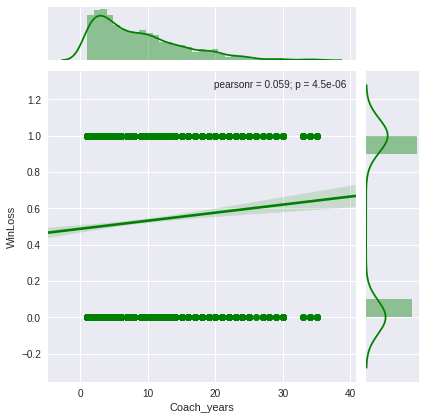

In [35]:
sns.jointplot(data=games, x='Coach_years', y='WinLoss', kind='reg', color='g')
sns.plt.show()

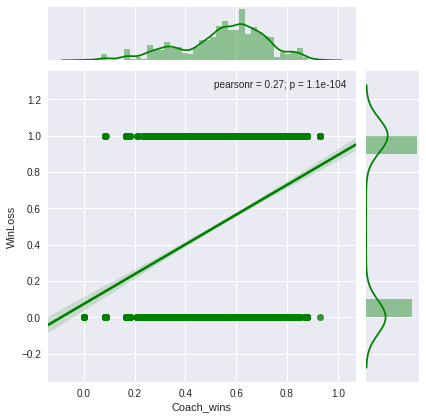

In [42]:
sns.jointplot(data=games, x='Coach_wins', y='WinLoss', kind='reg', color='g')
sns.plt.show()

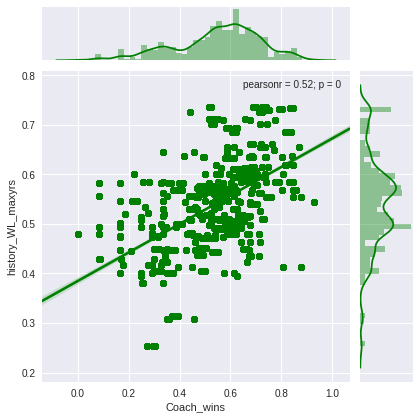

In [44]:
sns.jointplot(data=games, x='Coach_wins', y='history_WL_maxyrs', kind='reg', color='g')
sns.plt.show()

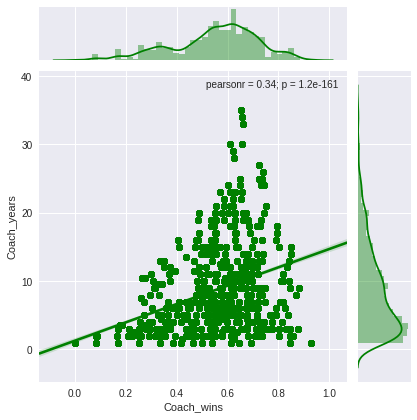

In [45]:
sns.jointplot(data=games, x='Coach_wins', y='Coach_years', kind='reg', color='g')
sns.plt.show()

In [54]:
pd.crosstab(games['HomeAway'], games['WinLoss'], margins=True)

WinLoss,0,1,All
HomeAway,,,
0,1727,1336,3063
1,1158,1857,3015
All,2885,3193,6078


In [55]:
print( games[['RushNetYards','TOP']].corr())

              RushNetYards       TOP
RushNetYards      1.000000  0.256656
TOP               0.256656  1.000000


In [57]:
print(games[['Coach_wins', 'history_WL_maxyrs', 'WinLoss']].corr())

                   Coach_wins  history_WL_maxyrs   WinLoss
Coach_wins           1.000000           0.520796  0.273745
history_WL_maxyrs    0.520796           1.000000  0.214389
WinLoss              0.273745           0.214389  1.000000
